In [1]:
import sys
import os
# print(os.getcwd())

project_root = os.path.abspath(os.path.join(os.getcwd(),"../../"))

sys.path.append(os.path.join(project_root,"src"))
# sys.path.append("src")

from cvi.preprocessing.cleaner import clean_text, preprocess_texts

In [2]:
import pandas as pd

df = pd.read_csv("../../data/amazon_reviews.csv")

/var/folders/p2/zc212sp14zxdyvjqklws806r0000gn/T/ipykernel_69704/3857340414.py:3: DtypeWarning: Columns (8,10,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/amazon_reviews.csv")


In [3]:
df.shape

(67992, 27)

In [4]:
df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'dateAdded', 'dateUpdated',
       'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs'],
      dtype='object')

In [5]:
df["clean_text"] = preprocess_texts(df["reviews.text"])

In [8]:
df["clean_text"].head()

0    product far disappoint child love use like abi...
1      great beginner experienced person buy gift love
2    inexpensive tablet use learn step nabi thrille...
3    fire week love tablet great prime member table...
4    buy grand daughter come visit set user enter a...
Name: clean_text, dtype: object

In [10]:
df["reviews.text"].head()

0    This product so far has not disappointed. My c...
1    great for beginner or experienced person. Boug...
2    Inexpensive tablet for him to use and learn on...
3    I've had my Fire HD 8 two weeks now and I love...
4    I bought this for my grand daughter when she c...
Name: reviews.text, dtype: object

In [11]:
def map_sentiment(rating):
    if rating in [1,2]:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

In [12]:
df["sentiment"] = df["reviews.rating"].apply(map_sentiment)

In [13]:
df["sentiment"].head()

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: sentiment, dtype: object

In [14]:
df["sentiment"].value_counts()

sentiment
Positive    62580
Neutral      2902
Negative     2510
Name: count, dtype: int64

In [15]:
binary_df = df[df["sentiment"] != "Neutral"].copy()

In [19]:
binary_df["sentiment"].value_counts()

sentiment
Positive    62580
Negative     2510
Name: count, dtype: int64

In [20]:
df.shape,binary_df.shape

((67992, 29), (65090, 29))

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = binary_df["clean_text"]
y = binary_df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size =0.2,
    random_state = 42,
    stratify = y
)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# here we are doing TF-IDF 
# Term frequency - Inverse Document Frequency 

In [24]:
vectorizer = TfidfVectorizer(
    max_features = 10000,
    ngram_range=(1,2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [53]:
X_train_tfidf.shape,X_test_tfidf.shape

((52072, 10000), (13018, 10000))

In [25]:
from sklearn.linear_model import LogisticRegression

In [27]:
model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [31]:
from sklearn.metrics import classification_report

In [32]:
y_pred = model.predict(X_test_tfidf)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.41      0.87      0.56       502
    Positive       0.99      0.95      0.97     12516

    accuracy                           0.95     13018
   macro avg       0.70      0.91      0.76     13018
weighted avg       0.97      0.95      0.96     13018



In [33]:
print(model.classes_)

['Negative' 'Positive']


In [34]:
y_probs = model.predict_proba(X_test_tfidf)[:,0]

In [36]:
import numpy as np

In [38]:
def evaluate_threshold(threshold):
    y_pred_custom = np.where(y_probs > threshold,"Negative","Positive")
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_test, y_pred_custom))

evaluate_threshold(0.3)
evaluate_threshold(0.5)
evaluate_threshold(0.7)
evaluate_threshold(0.8)


Threshold: 0.3
              precision    recall  f1-score   support

    Negative       0.26      0.93      0.40       502
    Positive       1.00      0.89      0.94     12516

    accuracy                           0.89     13018
   macro avg       0.63      0.91      0.67     13018
weighted avg       0.97      0.89      0.92     13018


Threshold: 0.5
              precision    recall  f1-score   support

    Negative       0.41      0.87      0.56       502
    Positive       0.99      0.95      0.97     12516

    accuracy                           0.95     13018
   macro avg       0.70      0.91      0.76     13018
weighted avg       0.97      0.95      0.96     13018


Threshold: 0.7
              precision    recall  f1-score   support

    Negative       0.60      0.80      0.68       502
    Positive       0.99      0.98      0.99     12516

    accuracy                           0.97     13018
   macro avg       0.79      0.89      0.83     13018
weighted avg       0.98   

In [39]:
import joblib

In [40]:
joblib.dump(model, "../../models/logistic_model.pkl")
joblib.dump(vectorizer, "../../models/tfidf_vectorizer.pkl")

['../../models/tfidf_vectorizer.pkl']

In [43]:
def predict_sentiment(text, threshold=0.8):
    text_clean = preprocess_texts([text])
    text_vec = vectorizer.transform(text_clean)
    prob_negative = model.predict_proba(text_vec)[0][0]

    if prob_negative > threshold:
        return "Negative", prob_negative
    else:
        return "Postive", 1 - prob_negative

In [45]:
predict_sentiment("This product is terrible and battery is worst")

('Negative', 0.9957704018762751)

In [46]:
predict_sentiment("Amazing quality and fast delivery")

('Postive', 0.9451738435398217)

In [47]:
from sentence_transformers import SentenceTransformer

In [49]:
# loading lightweight model
model_emb = SentenceTransformer("all-MiniLM-L6-v2")

In [50]:
# Generate embedding for cleaned text
embeddings = model_emb.encode(
    binary_df['clean_text'].tolist(),
    batch_size=64,
    show_progress_bar=True
)

Batches:   0%|          | 0/1018 [00:00<?, ?it/s]

In [52]:
embeddings.shape

(65090, 384)

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

In [57]:
# embedding of first review
query_embedding = embeddings[0].reshape(1,-1)

In [58]:
# compute similarity
similarities = cosine_similarity(query_embedding,embeddings)

In [59]:
# get top 5 most similar reviews

In [60]:
top_indices = np.argsort(similarities[0])[::-1][:6]

In [62]:
for idx in top_indices:
    print(binary_df["clean_text"].iloc[idx])
    print("Similarity:",similarities[0][idx])
    print("---------------")

product far disappoint child love use like ability monitor control content ease
Similarity: 1.0000002
---------------
product far disappoint child love use like ability monitor control content ease
Similarity: 1.0000002
---------------
product far disappoint child love use like ability monitor control content ease
Similarity: 1.0000002
---------------
daughter love parental control simple make easy monitor kid
Similarity: 0.74919516
---------------
daughter love parental control simple make easy monitor kid
Similarity: 0.7491951
---------------
daughter love parental control simple make easy monitor kid
Similarity: 0.7491951
---------------


In [157]:
negative_df = binary_df[binary_df["sentiment"] == "Negative"].reset_index(drop=True)
negative_df.shape

(2510, 30)

In [158]:
import hdbscan

In [159]:
# get embedding for negative reviews

In [160]:
negative_indices = negative_df.index
negative_embeddings = embeddings[negative_indices]

In [161]:
from sklearn.preprocessing import normalize

negative_embeddings_norm = normalize(negative_embeddings)

In [162]:
# Initialize HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size = 10,
    min_samples=5,
    metric = 'euclidean'
)

In [163]:
cluster_labels = clusterer.fit_predict(negative_embeddings_norm)

In [164]:
negative_df["cluster"] = cluster_labels

In [165]:
print("Number of cluster found:",len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0 ))
negative_df["cluster"].value_counts()

Number of cluster found: 2


cluster
-1    1825
 0     672
 1      13
Name: count, dtype: int64

In [112]:
cluster_0_samples = negative_df[negative_df["cluster"] == 0]["clean_text"].head(10)
for s in cluster_0_samples:
    print(s)
    print()

want site amazon want

kindle overloaded app use despite good buy associate say remove amazon app app memory pad love buy backup work unfortunately bog like amazon want access info set email use email likely sell craig list half pay

shop amazon time help easier lot ad pop use app non amazon source root complicated realistic alternative ipad galaxy note want device shop amazon love

buy early line vendor deliver good buy great

tablet well app actually work decently build amazon piece prime member great work flawlessly overcome terrible app behavior countless freeze need lesson apple

fire purchase die week purchase exchange new good sign far

let connect library diapointed

buy order watch nbc nbc app compatible paperweight

love tablet love sell ad time power loathe pay discontinue feature amazon want dollar kindle fire charge price device flash ad consumer opportunity unbecoming return item pronto

initially excited kindle extremely disappointed ad disappointed find pay amazon money

In [114]:
cluster_counts = negative_df["cluster"].value_counts()

In [115]:
cluster_counts

cluster
-1    1825
 0     672
 1      13
Name: count, dtype: int64

In [118]:
percentage = (cluster_counts[0]/len(negative_df)) * 100

In [119]:
print(f"\nCluter 0 represents {percentage:.2f}% of all negative reviews")


Cluter 0 represents 26.77% of all negative reviews


In [121]:
cluster_0_texts = negative_df[negative_df["cluster"] == 0]["clean_text"]

In [125]:
vectorizer_cluster = TfidfVectorizer(max_features=20)
X_cluster = vectorizer_cluster.fit_transform(cluster_0_texts)

In [126]:
print(vectorizer_cluster.get_feature_names_out())

['amazon' 'app' 'battery' 'brand' 'buy' 'charge' 'device' 'get' 'good'
 'kid' 'kindle' 'like' 'long' 'product' 'purchase' 'return' 'tablet'
 'time' 'use' 'work']


In [127]:
negative_df["clean_text"].head()

0                         feature look return day good
1    buy black friday hope awesome fail hard try mu...
2    buy tablet year old daughter advertisement pay...
3                                want site amazon want
4           good product short battery life use minute
Name: clean_text, dtype: object

In [128]:
vectorizer = TfidfVectorizer(max_features=5000)
x_all = vectorizer.fit_transform(negative_df["clean_text"])

In [129]:
feature_names = np.array(vectorizer.get_feature_names_out())

In [132]:
# get rows for cluster 0
cluster_0_mask = (negative_df["cluster"] == 0).values
X_cluster_0 = x_all[cluster_0_mask]

In [134]:
# compute mean TF-IDF score per word inside cluster 0
mean_tfidf = np.asarray(X_cluster_0.mean(axis = 0)).flatten()

In [135]:
# get top words

In [136]:
top_indices = mean_tfidf.argsort()[::-1][:20]

In [137]:
print(feature_names[top_indices])

['battery' 'long' 'buy' 'work' 'amazon' 'good' 'use' 'app' 'tablet' 'time'
 'charge' 'return' 'purchase' 'get' 'brand' 'kid' 'product' 'fast'
 'kindle' 'week']


In [139]:
import random

samples = negative_df[negative_df["cluster"] == 0]["clean_text"].sample(10)

for s in samples:
    print(s)
    print()

problem month luckily credit kindle ipad start work fine month start lose internet connection randomly old ipad problem stop charge get past try different outlet different android charger worthless

use regular battery powered item dead brand use item time replace battery

purchase kid hard navigate end purchase ipad

drain way quickly

battery bad use wireless mouse work replace battery week instead year like old battery time figure bad outside return window fail amazon ask make question shop

use android hard return get andriod

turn return

cheap battery matter worse amazon send old dead battery mix new one ship half final package dead battery work maybe day amazon return money waste time

good describe power easy

battery wear quickly replace weather station go set battery month luckily kind battery burn day realize battery bad electronic



In [140]:
cluster_counts = negative_df["cluster"].value_counts()

In [141]:
total_negatives = len(negative_df)
major_cluster_size = cluster_counts[0]

percentage = (major_cluster_size/total_negatives) * 100

In [144]:
print(f"Total negative reviews: {total_negatives}")
print(f"Major cluster size: {major_cluster_size}")
print(f"Percentage of negative reviews: {percentage:.2f}%")

Total negative reviews: 2510
Major cluster size: 672
Percentage of negative reviews: 26.77%


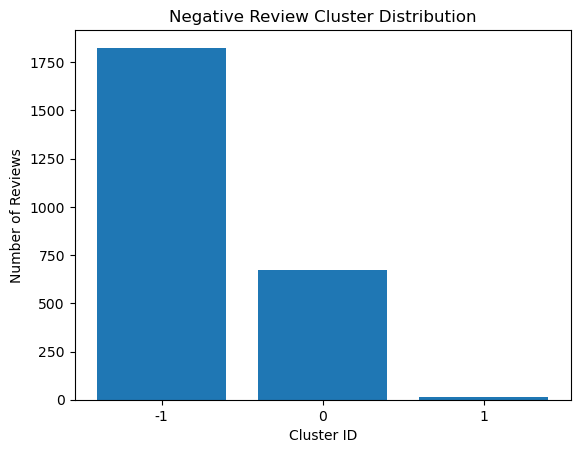

In [145]:
import matplotlib.pyplot as plt

cluster_counts_sorted = cluster_counts.sort_index()

plt.figure()
plt.bar(cluster_counts_sorted.index.astype(str),
       cluster_counts_sorted.values)

plt.xlabel("Cluster ID")
plt.ylabel("Number of Reviews")
plt.title("Negative Review Cluster Distribution")

plt.show()

In [147]:
binary_df["review_month"] = (pd.to_datetime(binary_df["reviews.date"],format="ISO8601").dt.to_period("M"))

/var/folders/p2/zc212sp14zxdyvjqklws806r0000gn/T/ipykernel_69704/2077873857.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  binary_df["review_month"] = (pd.to_datetime(binary_df["reviews.date"],format="ISO8601").dt.to_period("M"))


In [151]:
binary_df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'dateAdded', 'dateUpdated',
       'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs',
       'clean_text', 'sentiment', 'review_month'],
      dtype='object')

In [156]:
negative_df = binary_df[binary_df["sentiment"] == "Negative"].reset_index(drop=True) 

In [154]:
print("Unique months:",negative_df["review_month"].nunique())
print(sorted(negative_df["review_month"].dropna().unique()))

Unique months: 55
[Period('2009-10', 'M'), Period('2010-09', 'M'), Period('2010-10', 'M'), Period('2011-01', 'M'), Period('2011-09', 'M'), Period('2011-11', 'M'), Period('2012-10', 'M'), Period('2012-11', 'M'), Period('2012-12', 'M'), Period('2013-10', 'M'), Period('2013-12', 'M'), Period('2014-02', 'M'), Period('2014-06', 'M'), Period('2014-11', 'M'), Period('2014-12', 'M'), Period('2015-01', 'M'), Period('2015-03', 'M'), Period('2015-04', 'M'), Period('2015-05', 'M'), Period('2015-06', 'M'), Period('2015-07', 'M'), Period('2015-08', 'M'), Period('2015-09', 'M'), Period('2015-10', 'M'), Period('2015-11', 'M'), Period('2015-12', 'M'), Period('2016-01', 'M'), Period('2016-02', 'M'), Period('2016-03', 'M'), Period('2016-04', 'M'), Period('2016-05', 'M'), Period('2016-06', 'M'), Period('2016-07', 'M'), Period('2016-08', 'M'), Period('2016-09', 'M'), Period('2016-10', 'M'), Period('2016-11', 'M'), Period('2016-12', 'M'), Period('2017-01', 'M'), Period('2017-02', 'M'), Period('2017-03', 'M'

In [166]:
monthly_counts = negative_df.groupby(["review_month","cluster"]).size().reset_index(name="count")

In [167]:
monthly_totals = negative_df.groupby("review_month").size().reset_index(name="total_neg")

In [174]:
monthly_data = monthly_counts.merge(monthly_totals,on="review_month")

In [175]:
monthly_data["share"] = monthly_data["count"]/monthly_data["total_neg"]

In [179]:
battery_trend = monthly_data[monthly_data["cluster"] == 0]

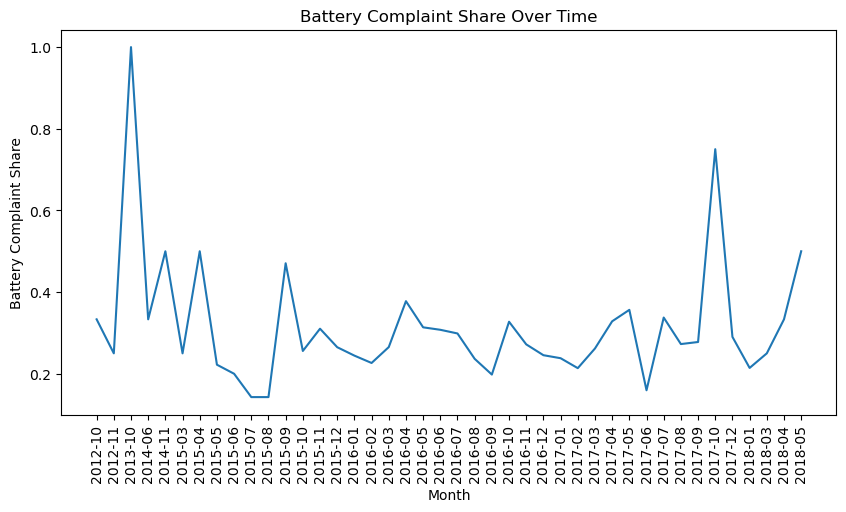

In [182]:
plt.figure(figsize=(10,5))
plt.plot(
    battery_trend["review_month"].astype(str),
    battery_trend["share"]
)

plt.xticks(rotation=90)
plt.xlabel("Month")
plt.ylabel("Battery Complaint Share")
plt.title("Battery Complaint Share Over Time")

plt.show()

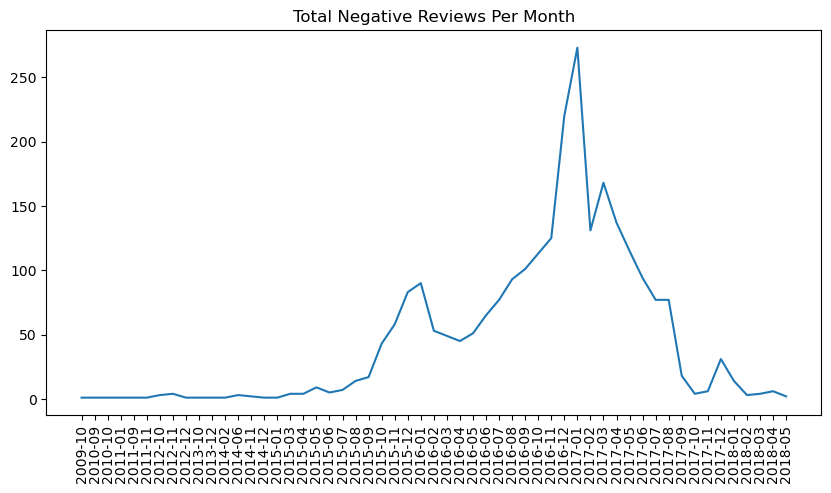

In [184]:
monthly_totals = negative_df.groupby("review_month").size()

plt.figure(figsize=(10,5))
plt.plot(monthly_totals.index.astype(str), monthly_totals.values)
plt.xticks(rotation=90)
plt.title("Total Negative Reviews Per Month")
plt.show()


In [185]:
# alert System 

battery_mean = battery_trend["share"].mean()
battery_std = battery_trend["share"].std()

print("Mean: ",battery_mean)
print("Std Dev: ",battery_std)

Mean:  0.3160560218576568
Std Dev:  0.15553282228292847


In [186]:
battery_trend = battery_trend.sort_values("review_month")
battery_trend["prev_share"] = battery_trend["share"].shift(1)
battery_trend["delta"] = battery_trend["share"] - battery_trend["prev_share"]

alerts = battery_trend[battery_trend["delta"] > 0.1]

print("! Potential Risk Months:")
print(alerts[["review_month","share","delta"]])

! Potential Risk Months:
    review_month     share     delta
11       2013-10  1.000000  0.750000
17       2014-11  0.500000  0.166667
23       2015-04  0.500000  0.250000
33       2015-09  0.470588  0.327731
49       2016-04  0.377778  0.112472
64       2016-10  0.327434  0.129414
86       2017-07  0.337662  0.178088
93       2017-10  0.750000  0.472222
105      2018-05  0.500000  0.166667


In [189]:
monthly_totals = negative_df.groupby("review_month").size().reset_index(name="total_neg")
battery_trend = battery_trend.merge(monthly_totals,on="review_month")
alerts = battery_trend[
    (battery_trend["delta"] > 0.10) & (battery_trend["total_neg"] >=30)
]
print("! Vlid Risk Months:")
print(alerts[["review_month","share","delta","total_neg"]])

! Vlid Risk Months:
   review_month     share     delta  total_neg
18      2016-04  0.377778  0.112472         45
24      2016-10  0.327434  0.129414        113
33      2017-07  0.337662  0.178088         77
